#PIP


In [ ]:
!pip install pmdarima
!pip install keras
!!pip install scikeras
!pip install optuna
!pip install lightgbm --upgrade

#Librerias


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
import seaborn as sns  # biblioteca para gráficos estadísticos
from statsmodels.tsa.seasonal import STL
import numpy as np


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Datami.xlsx')

In [ ]:
#dfl es solo para visualizar los valores de quantity anomalos
df = df[df['Quantity'] < 0]

In [ ]:
df.shape


(284622, 8)

In [ ]:
df = df[df['Quantity'] >= -35]

In [ ]:
df['Turnover'] = df['Turnover'].abs()
df['Quantity'] = df['Quantity'].abs()
df['qty'] = df['qty'].abs()

In [ ]:
df

,item_number,date,Quantity,item_description,price,qty,Turnover,Week
0,598000120.0,2022-12-14,1.0,Fried Cheese Empanada,1190.0,42.0,42000.0,50.0
1,598000120.0,2023-03-07,1.0,Fried Cheese Empanada,1190.0,10.0,10000.0,10.0
2,598000120.0,2022-12-12,1.0,Fried Cheese Empanada,1190.0,15.0,15000.0,50.0
3,598000120.0,2022-12-30,1.0,Fried Cheese Empanada,1190.0,56.0,56000.0,52.0
4,598000120.0,2022-10-17,1.0,Fried Cheese Empanada,1190.0,13.0,13000.0,42.0
...,...,...,...,...,...,...,...,...
284614,789000138.0,2024-01-07,4.0,Coca cola zero can 350 ml.,1190.0,4.0,4000.0,1.0
284615,789000138.0,2023-06-20,3.0,Coca cola zero can 350 ml.,1190.0,3.0,3000.0,25.0
284616,789000138.0,2023-09-28,3.0,Coca cola zero can 350 ml.,1190.0,3.0,3000.0,39.0
284617,789000138.0,2024-03-16,4.0,Coca cola zero can 350 ml.,1190.0,4.0,4000.0,11.0


#Serie temporal por día


In [ ]:
dff=df.copy()

In [ ]:
temp = dff.groupby('date')['Turnover'].size()
temp[temp > 1].sort_values(ascending=False)

,Turnover
date,
2023-12-09,674
2024-03-03,673
2023-12-02,663
2024-03-30,659
2024-01-27,658
...,...
2022-08-04,104
2022-08-05,98
2022-07-27,88


In [ ]:

dff = dff.groupby('date')['Turnover'].sum().reset_index()
dff = dff.set_index('date')
dff.index
dff.sample(10)

,Turnover
date,
2023-04-10,8.202996e+06
2023-09-01,9.058368e+06
2023-12-05,1.040007e+07
2024-01-31,1.073680e+07
2024-05-31,1.042097e+07
2023-02-13,8.448089e+06
2023-08-18,8.447160e+06
2022-12-14,1.554286e+07
2022-12-21,1.124614e+07


In [ ]:
# Generar un rango de fechas completo entre la fecha de inicio y la fecha de término
rango_completo = pd.date_range(start=dff.index.min(), end=dff.index.max(), freq='D')

# Identificar las fechas faltantes
fechas_faltantes = rango_completo.difference(dff.index)

# Mostrar resultados
if fechas_faltantes.empty:
    print("No hay fechas faltantes en la serie de tiempo.")
else:
    print(f"Hay {len(fechas_faltantes)} fechas faltantes en la serie de tiempo:")
    print(fechas_faltantes)
# Reindexar el DataFrame para incluir las fechas faltantes
dff = dff.reindex(rango_completo)

# Interpolar los valores faltantes
dff['Turnover'] = dff['Turnover'].interpolate(method='time')

# Verificar si la interpolación fue exitosa
print("Valores interpolados:")
print(dff.loc[fechas_faltantes])

Hay 20 fechas faltantes en la serie de tiempo:
DatetimeIndex(['2022-07-28', '2022-07-30', '2022-07-31', '2022-08-06',
               '2022-08-07', '2022-08-08', '2022-09-04', '2022-09-18',
               '2022-09-19', '2022-12-25', '2023-01-01', '2023-04-07',
               '2023-05-01', '2023-05-07', '2023-09-18', '2023-09-19',
               '2023-12-17', '2023-12-25', '2024-01-01', '2024-05-01'],
              dtype='datetime64[ns]', freq=None)
Valores interpolados:
                Turnover
2022-07-28  6.776849e+05
2022-07-30  1.894627e+05
2022-07-31  9.497927e+04
2022-08-06  1.558146e+06
2022-08-07  1.039182e+06
2022-08-08  5.202168e+05
2022-09-04  9.945752e+06
2022-09-18  8.393511e+06
2022-09-19  8.343600e+06
2022-12-25  1.281784e+07
2023-01-01  1.552788e+07
2023-04-07  2.473150e+07
2023-05-01  1.870433e+07
2023-05-07  1.836453e+07
2023-09-18  1.112016e+07
2023-09-19  1.060048e+07
2023-12-17  1.902692e+07
2023-12-25  7.792526e+06
2024-01-01  7.446197e+06
2024-05-01  7.580971e+06


<Figure size 2000x800 with 0 Axes>

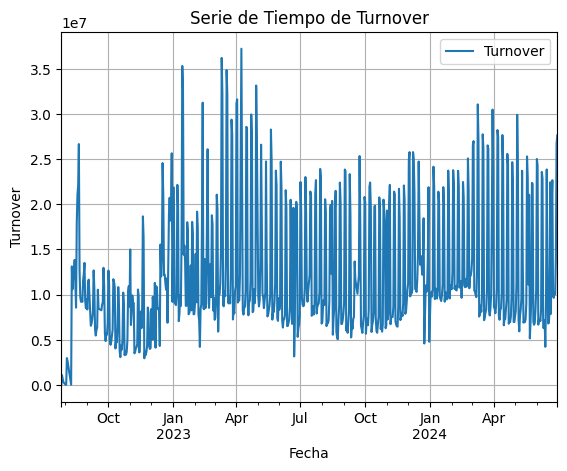

In [ ]:
plt.figure(figsize=(20, 8))  # Ajusta el tamaño de la figura
dff.plot()
plt.title('Serie de Tiempo de Turnover')
plt.xlabel('Fecha')
plt.ylabel('Turnover')
plt.grid(True)
plt.show()

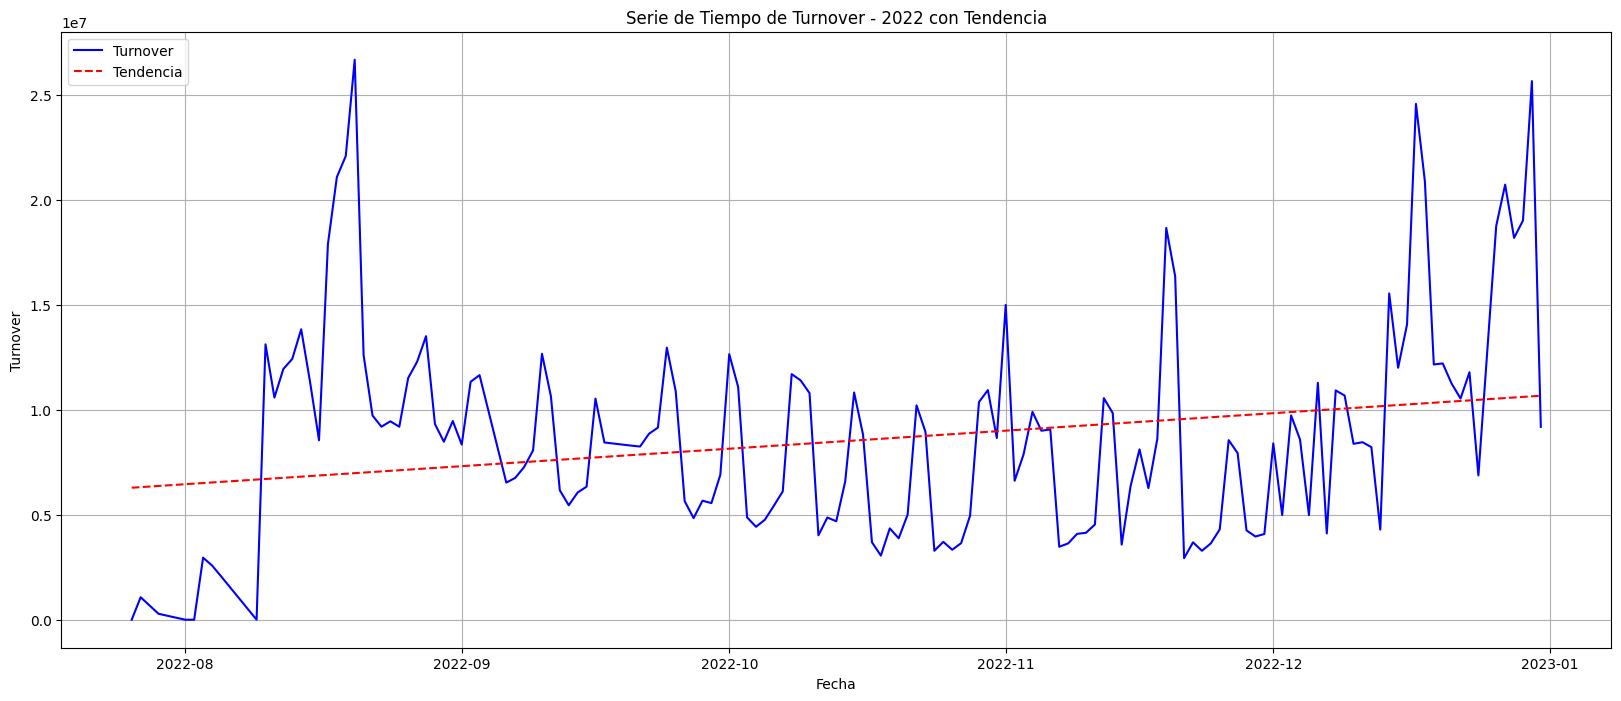

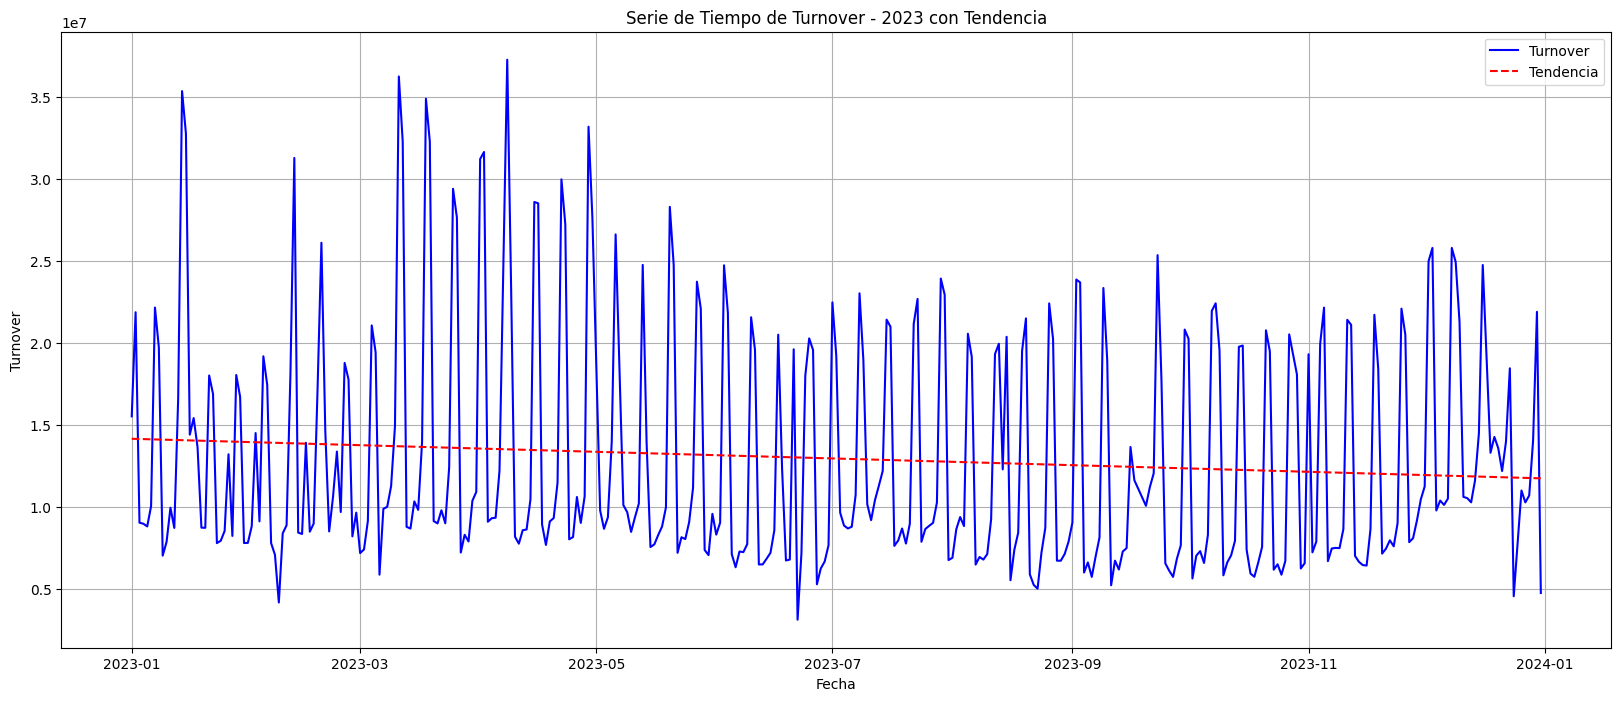

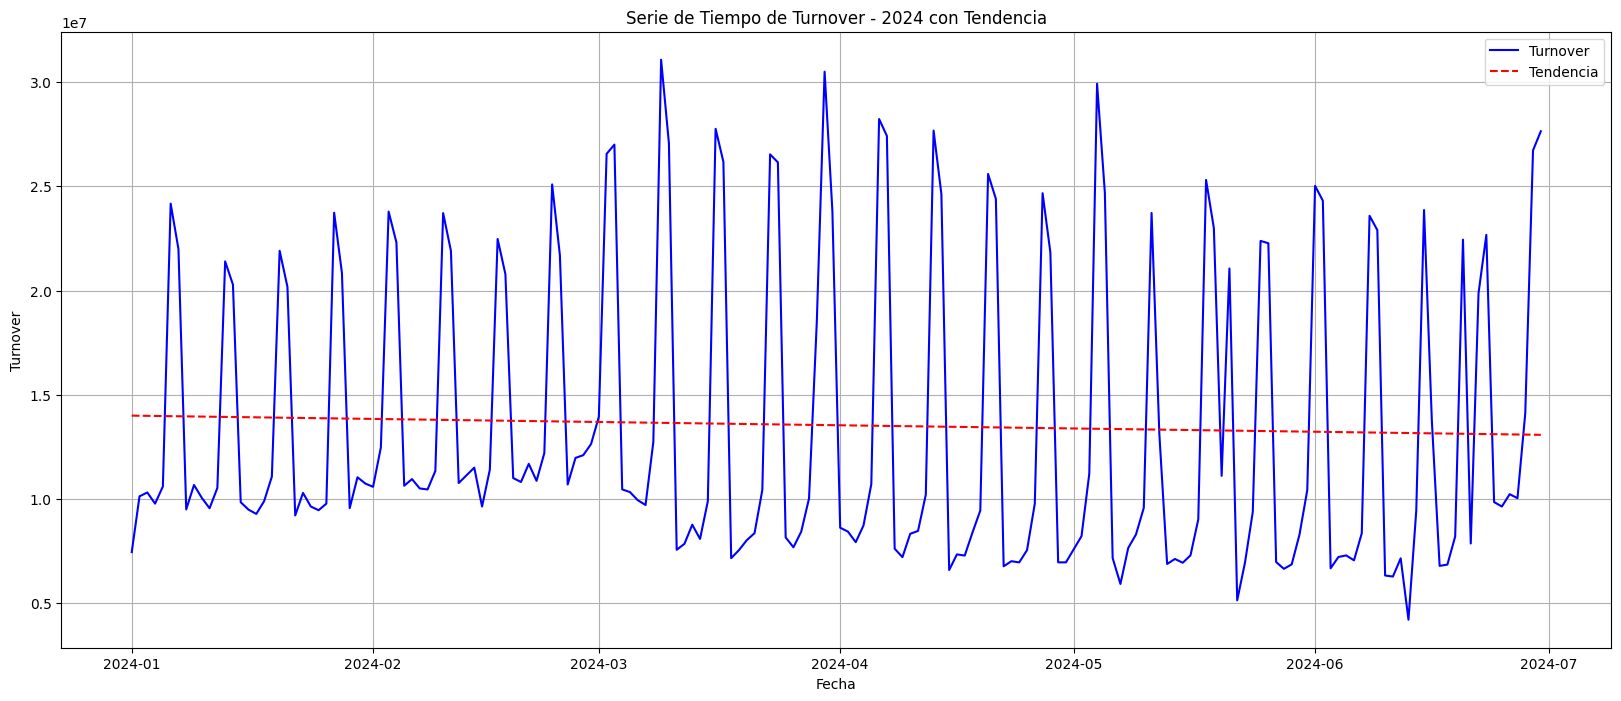

In [ ]:
# Asegúrate de que el índice del DataFrame es un DatetimeIndex
dff.index = pd.to_datetime(dff.index)

# Extraer los años únicos del índice de fechas
years = dff.index.year.unique()

for year in years:
    plt.figure(figsize=(20, 8))
    data_for_year = dff[dff.index.year == year]  # Filtrar datos por año

    # Graficar la serie temporal
    plt.plot(data_for_year.index, data_for_year['Turnover'], label='Turnover', color='blue')

    # Calcular y graficar la línea de tendencia
    x = np.arange(len(data_for_year))
    y = data_for_year['Turnover']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(data_for_year.index, p(x), linestyle='--', label='Tendencia', color='red')

    # Añadir título y etiquetas
    plt.title(f'Serie de Tiempo de Turnover - {year} con Tendencia')
    plt.xlabel('Fecha')
    plt.ylabel('Turnover')
    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-15-4adf0af5282c>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(years))


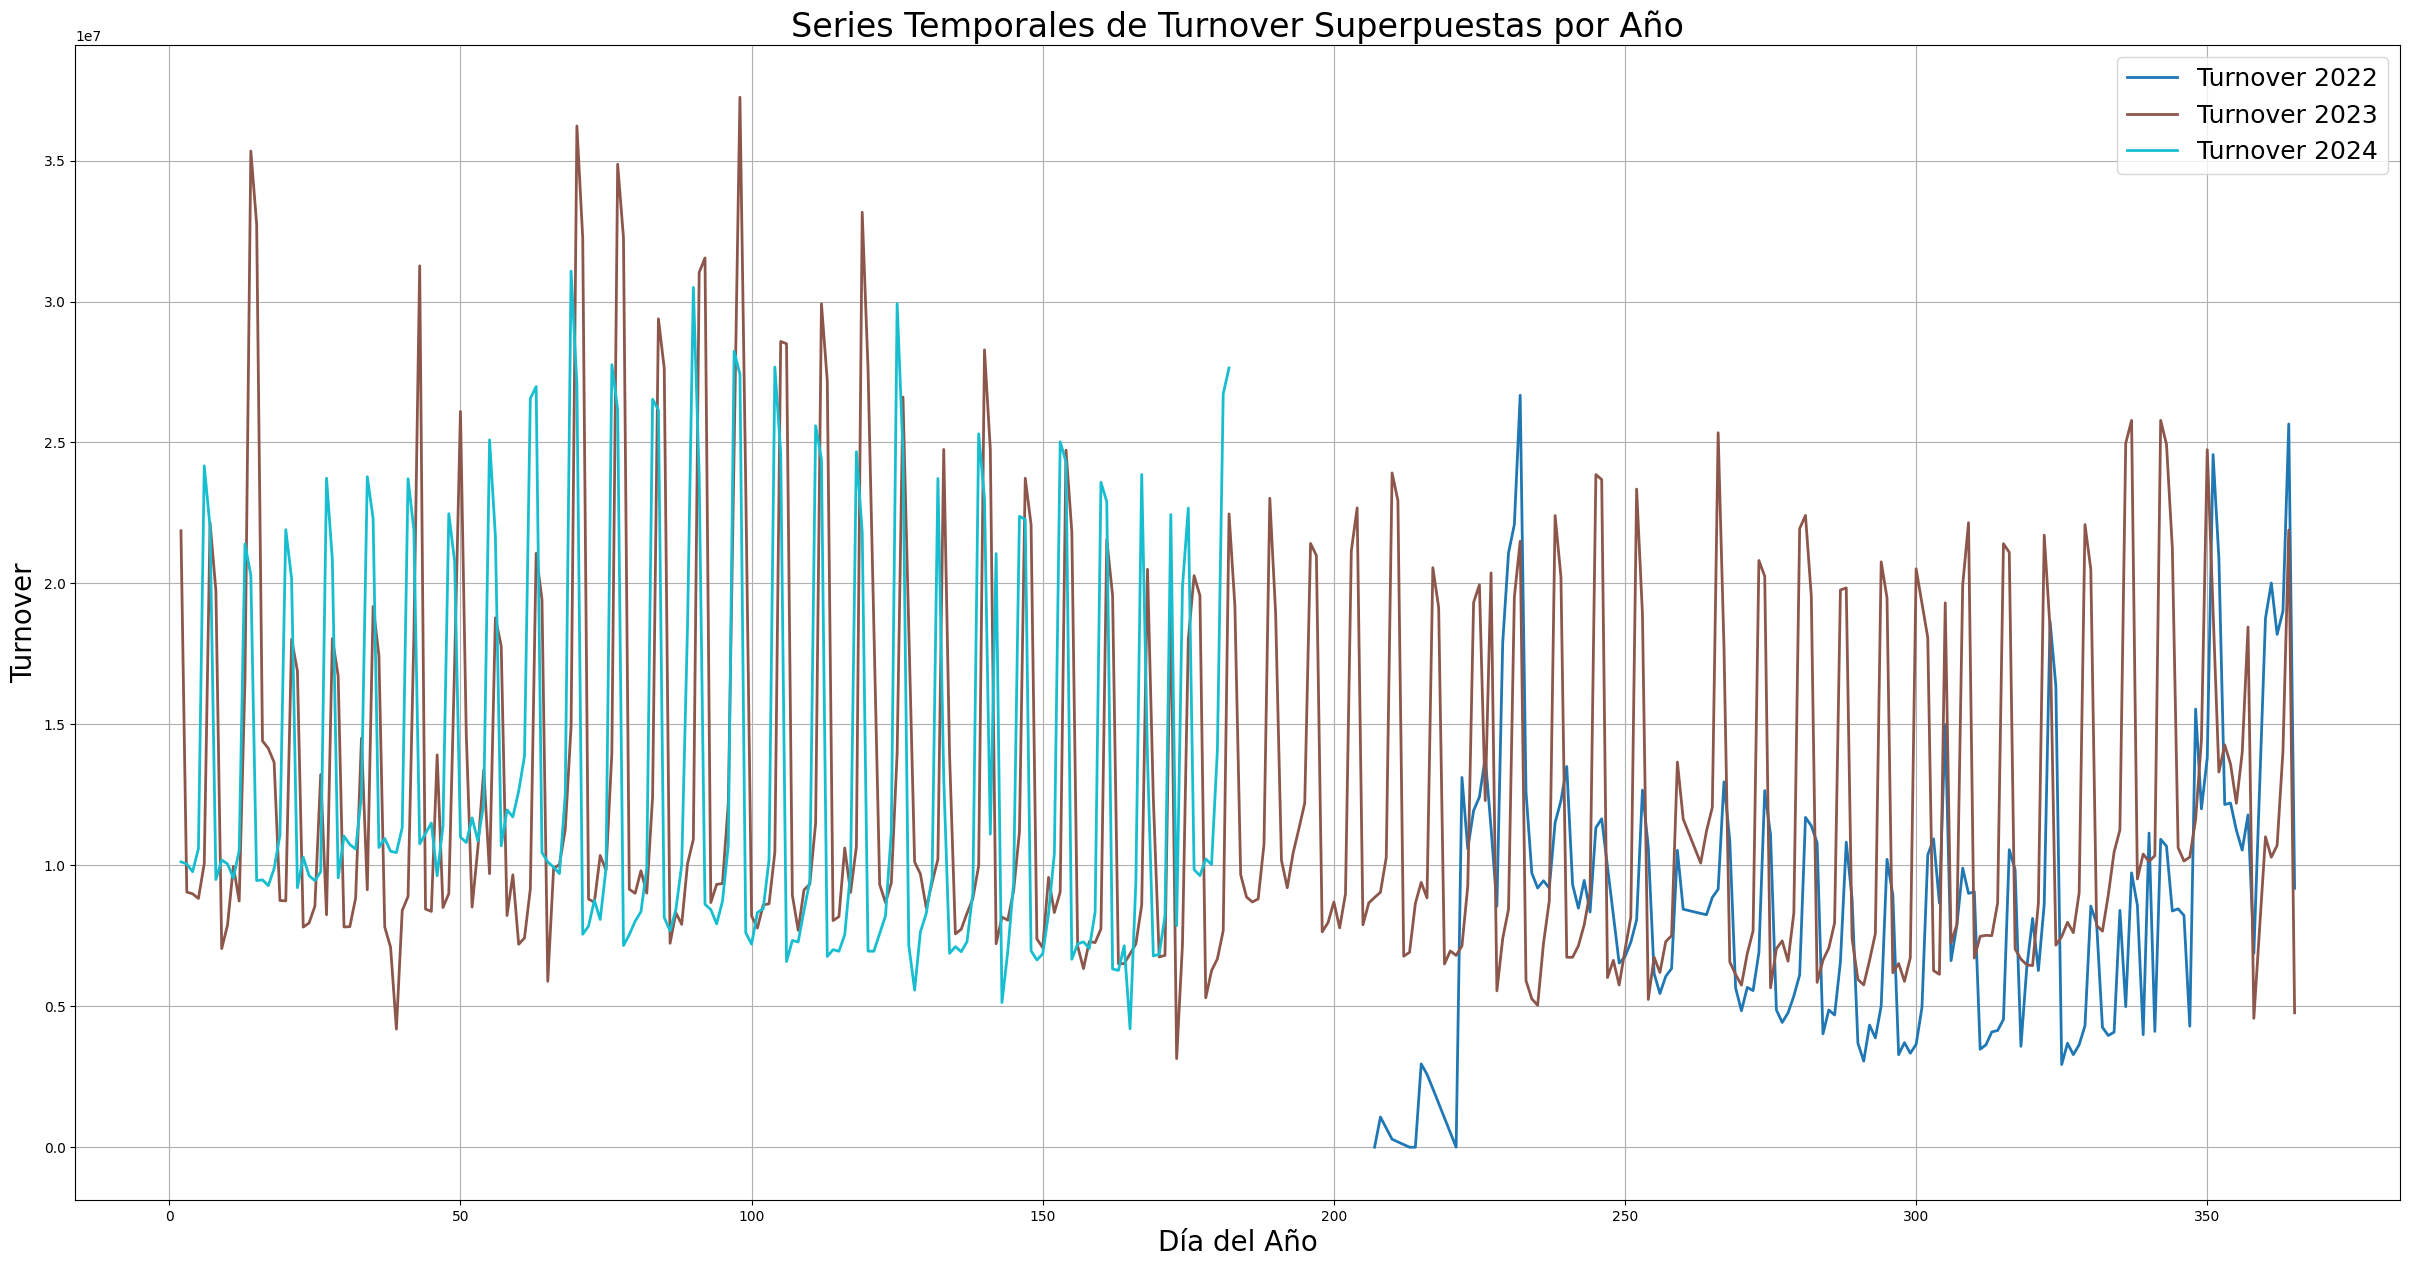

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(30, 15))  # Tamaño de 30x15 pulgadas

# Colores para cada año
colors = plt.cm.get_cmap('tab10', len(years))

for i, year in enumerate(years):
    data_for_year = dff[dff.index.year == year]  # Filtrar datos por año

    # Normalizar el tiempo para que todos los años comiencen en el mismo punto
    plt.plot(data_for_year.index.dayofyear, data_for_year['Turnover'], label=f'Turnover {year}', color=colors(i), linewidth=2)

# Añadir título y etiquetas
plt.title('Series Temporales de Turnover Superpuestas por Año', fontsize=24)
plt.xlabel('Día del Año', fontsize=20)
plt.ylabel('Turnover', fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

#Serie temporal por semana

In [ ]:
df2=df.copy()

In [ ]:
df2.head()

,item_number,date,Quantity,item_description,price,qty,Turnover,Week
0,598000120.0,2022-12-14,1.0,Fried Cheese Empanada,1190.0,42.0,42000.0,50.0
1,598000120.0,2023-03-07,1.0,Fried Cheese Empanada,1190.0,10.0,10000.0,10.0
2,598000120.0,2022-12-12,1.0,Fried Cheese Empanada,1190.0,15.0,15000.0,50.0
3,598000120.0,2022-12-30,1.0,Fried Cheese Empanada,1190.0,56.0,56000.0,52.0
4,598000120.0,2022-10-17,1.0,Fried Cheese Empanada,1190.0,13.0,13000.0,42.0


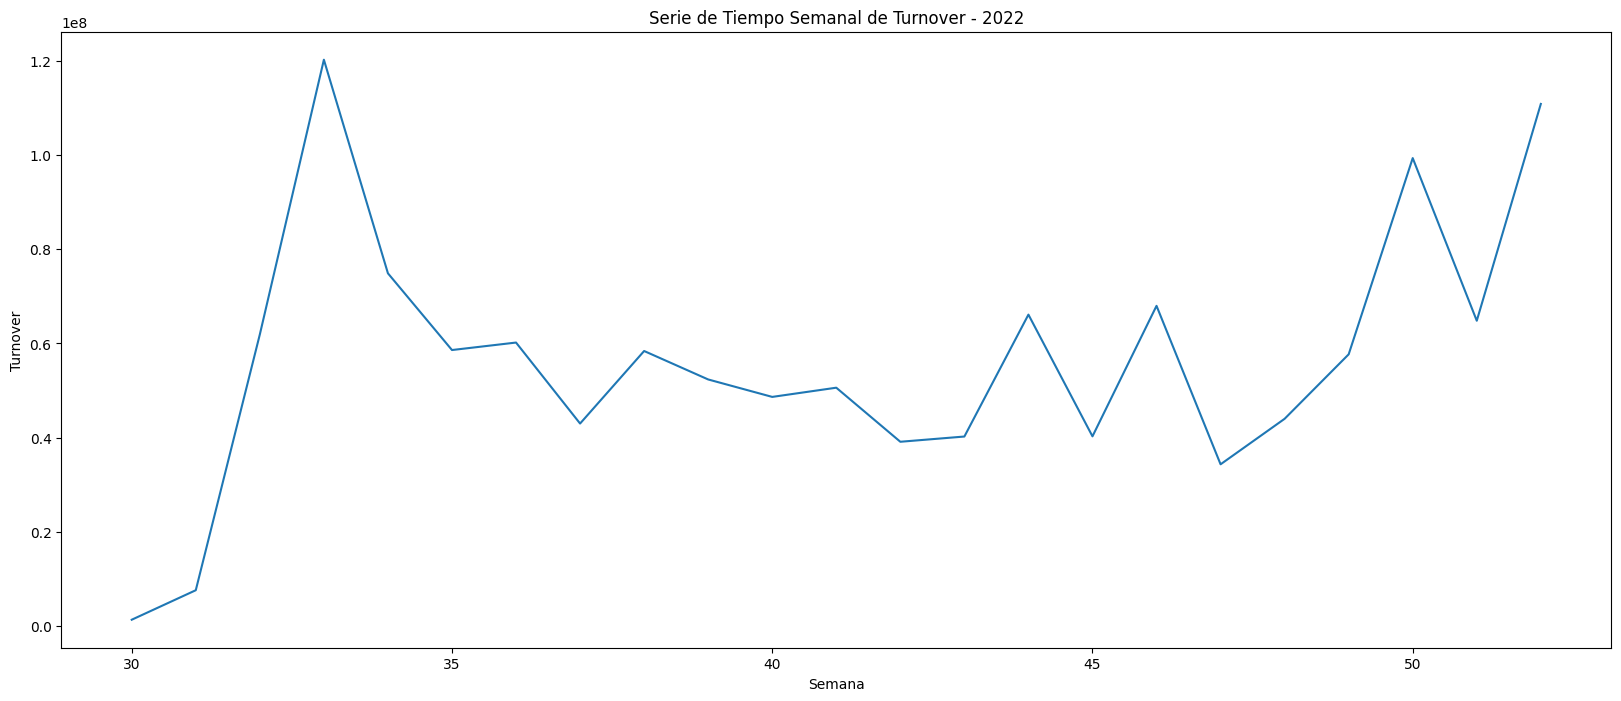

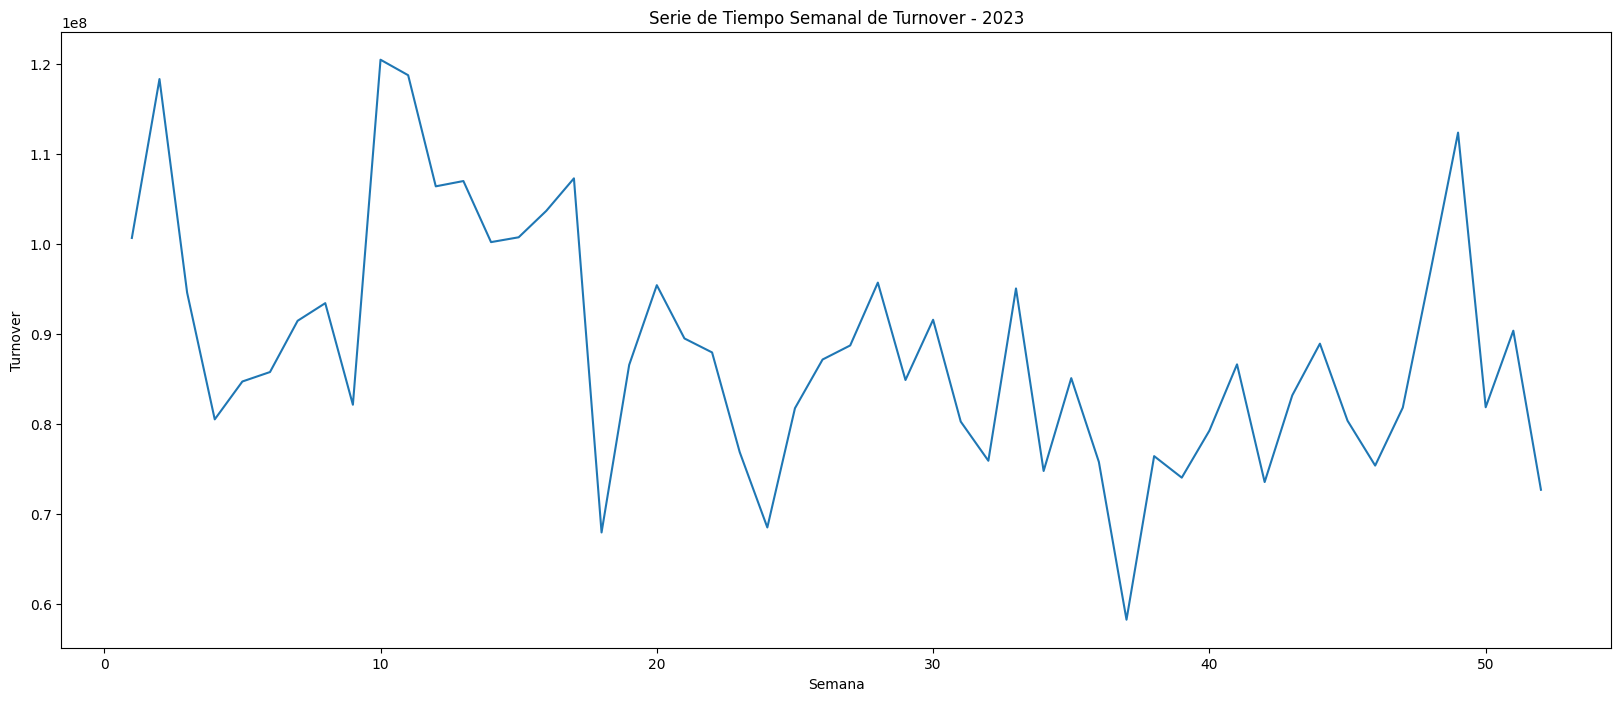

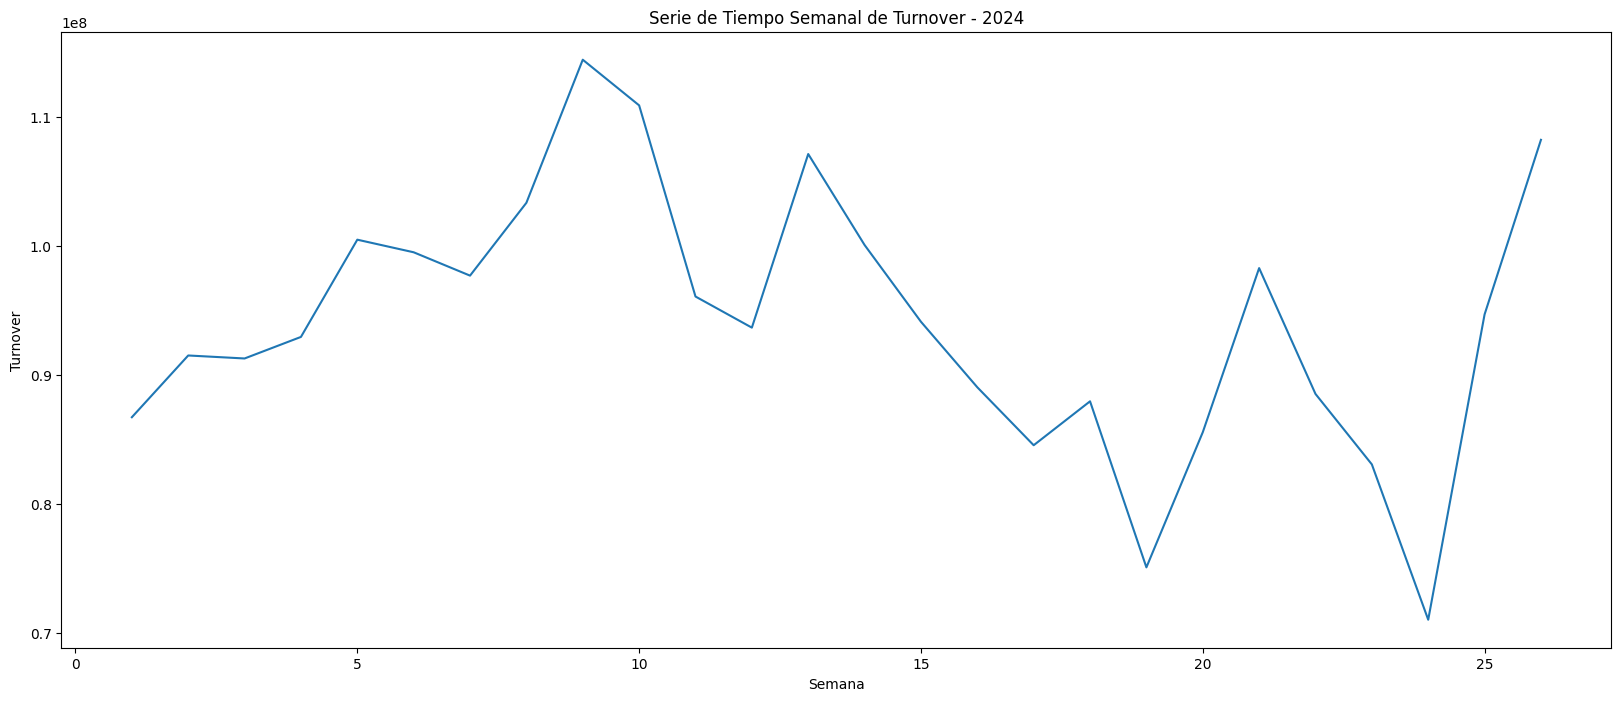

In [ ]:
# Asegurarse de que la columna 'date' es de tipo datetime
df2['date'] = pd.to_datetime(df2['date'])

# Extraer el año de la columna 'date' y crear una nueva columna 'year'
df2['year'] = df2['date'].dt.year

# Graficar la serie de tiempo semanal por cada año
for year in df2['year'].unique():
    plt.figure(figsize=(20, 8))

    # Filtrar los datos para el año actual
    data_for_year = df2[df2['year'] == year]

    # Agrupar por semana y sumar el Turnover
    weekly_data = data_for_year.groupby('Week')['Turnover'].sum()

    # Graficar la serie temporal semanal
    weekly_data.plot()

    # Configurar el título y las etiquetas
    plt.title(f'Serie de Tiempo Semanal de Turnover - {year}')
    plt.xlabel('Semana')
    plt.ylabel('Turnover')

In [ ]:
dfd = dff.copy()  # Hacer una copia del DataFrame original

# Iterar solo sobre valores impares en el rango deseado
seasonal_values = range(7, 31, 2)  # Usar un paso de 2 para obtener solo números impares
best_seasonal = None
best_resid_std = np.inf  # Inicializar con un valor alto

for s in seasonal_values:
    stl = STL(dfd['Turnover'], seasonal=s)
    result = stl.fit()
    resid_std = np.std(result.resid)  # Desviación estándar de los residuos

    if resid_std < best_resid_std:
        best_resid_std = resid_std
        best_seasonal = s

print(f"El valor óptimo para 'seasonal' es: {best_seasonal}")

El valor óptimo para 'seasonal' es: 7


<Figure size 1400x1000 with 0 Axes>

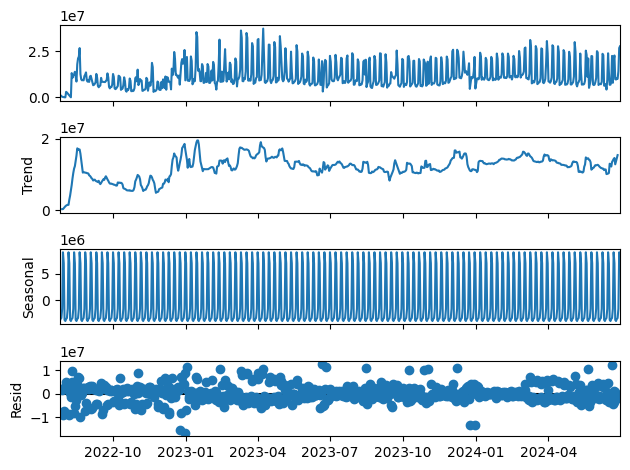

El periodo de estacionalidad identificado es aproximadamente 7 periodos.


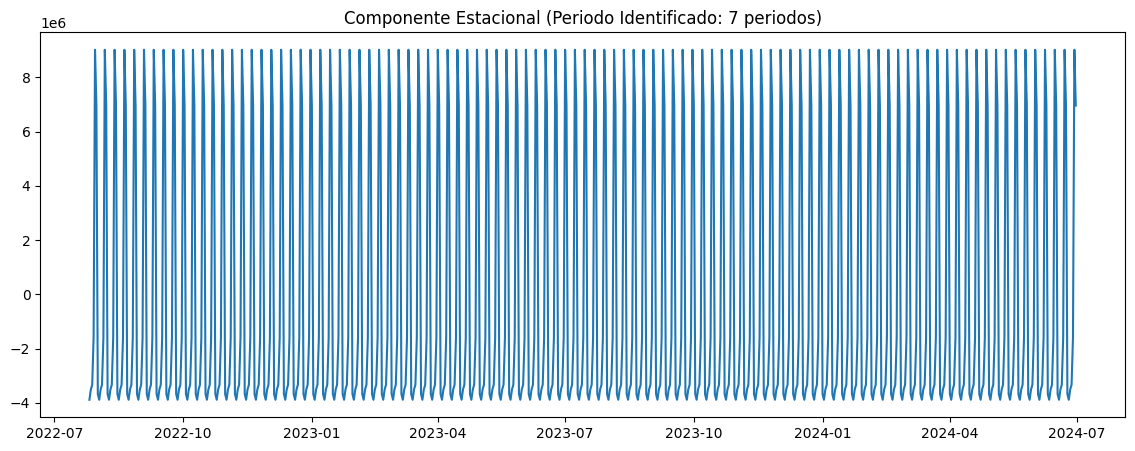

In [ ]:
dfd=dff.copy()
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Descomposición de la serie temporal
decomposition = seasonal_decompose(dfd, model='additive', period=7)

# Plot de la descomposición con gráficos más grandes
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()

# Análisis del componente estacional
estacional = decomposition.seasonal

# Identificación del periodo de estacionalidad utilizando autocorrelación
autocorrelacion = np.correlate(estacional, estacional, mode='full')
autocorrelacion = autocorrelacion[autocorrelacion.size // 2:]

# Encontrar el primer pico significativo en la autocorrelación que indique el periodo
periodo_estacional = np.argmax(autocorrelacion[1:]) + 1

# Mostrar el periodo de estacionalidad identificado
print(f"El periodo de estacionalidad identificado es aproximadamente {periodo_estacional} periodos.")

# Verificar visualmente la estacionalidad
plt.figure(figsize=(14, 5))
plt.plot(estacional)
plt.title(f'Componente Estacional (Periodo Identificado: {periodo_estacional} periodos)')
plt.show()

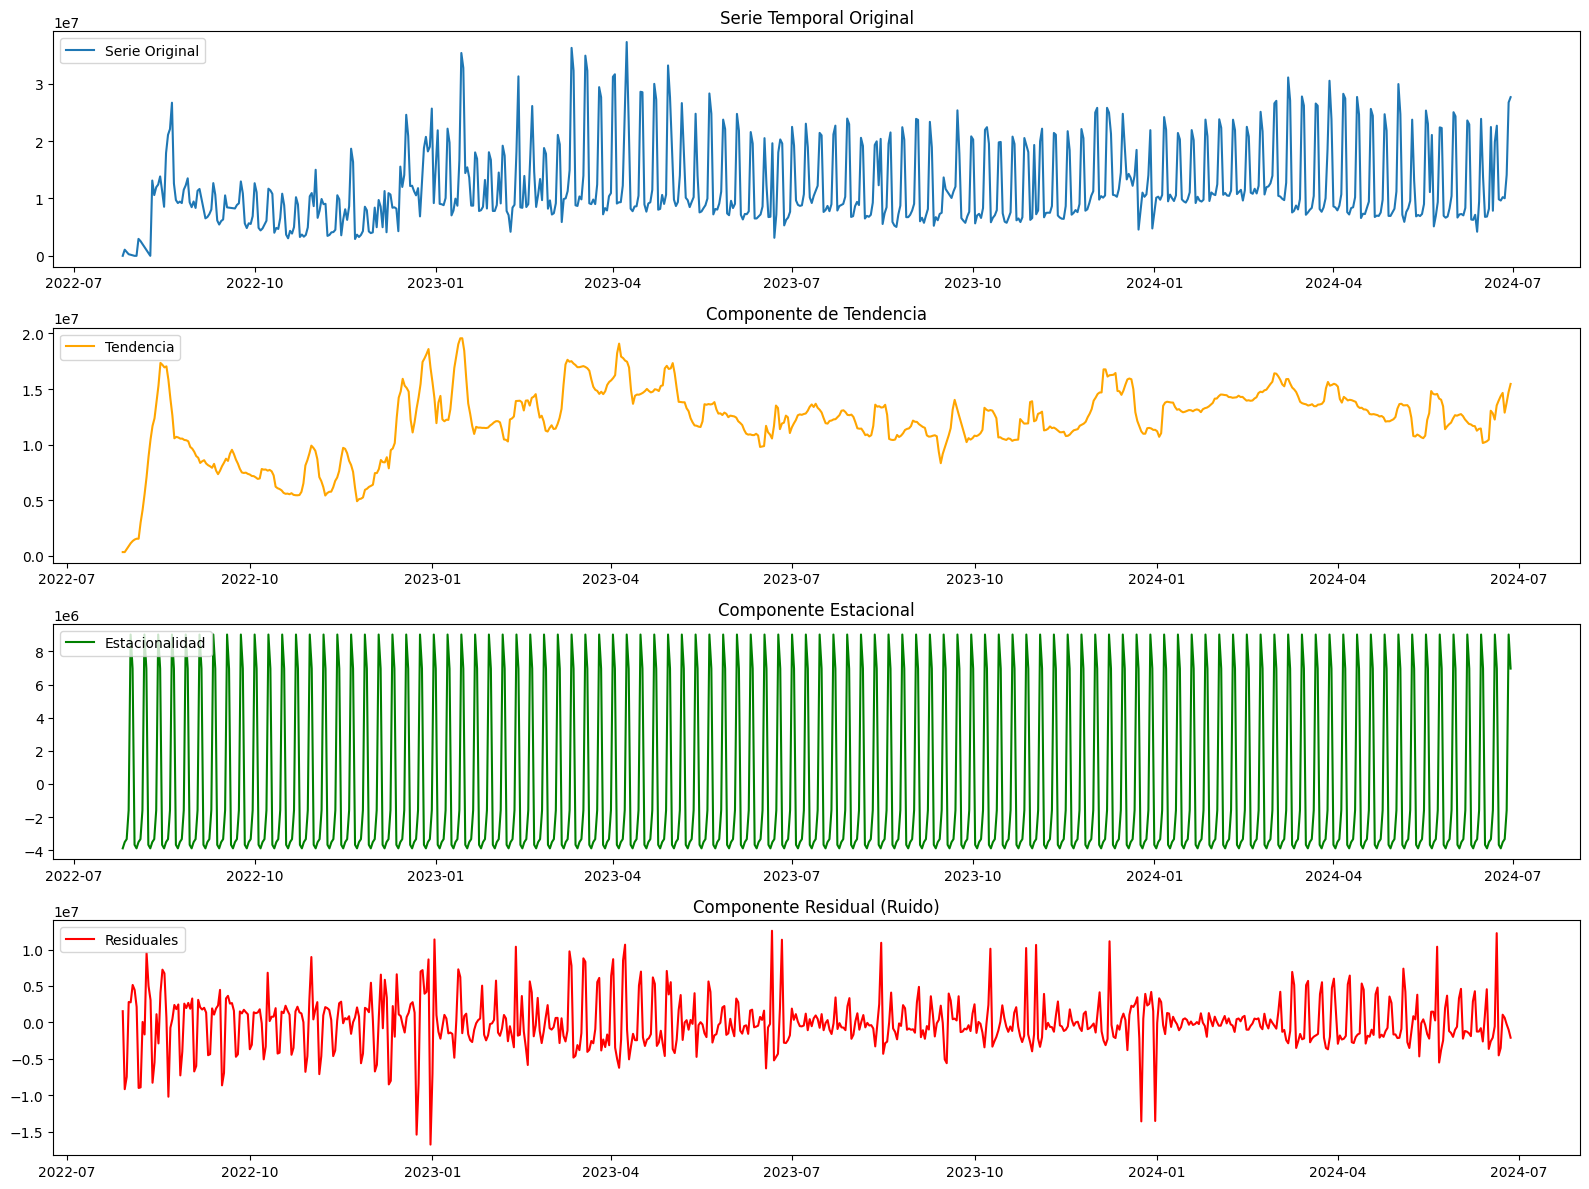

El periodo de estacionalidad identificado es aproximadamente 7 periodos.


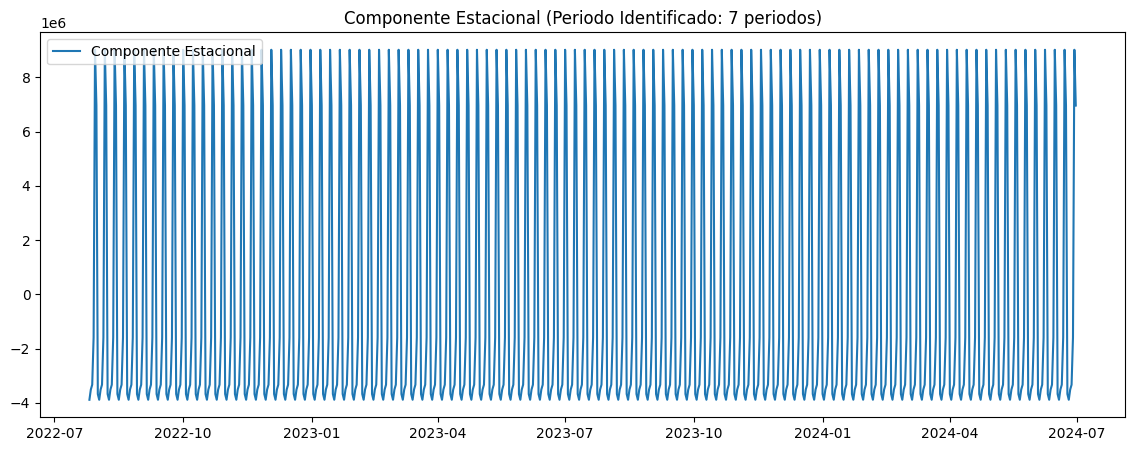

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Copiar el DataFrame
dfd = dff.copy()

# Descomposición de la serie temporal
decomposition = seasonal_decompose(dfd, model='additive', period=7)

# Crear una figura con subplots organizados para cada componente
plt.figure(figsize=(16, 12))

# Componente Observada
plt.subplot(4, 1, 1)
plt.plot(dfd, label='Serie Original')
plt.title('Serie Temporal Original')
plt.legend(loc='upper left')

# Componente de Tendencia
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Tendencia', color='orange')
plt.title('Componente de Tendencia')
plt.legend(loc='upper left')

# Componente Estacional
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Estacionalidad', color='green')
plt.title('Componente Estacional')
plt.legend(loc='upper left')

# Componente de Ruido (Residuos)
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuales', color='red')
plt.title('Componente Residual (Ruido)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Análisis del componente estacional
estacional = decomposition.seasonal

# Identificación del periodo de estacionalidad utilizando autocorrelación
autocorrelacion = np.correlate(estacional, estacional, mode='full')
autocorrelacion = autocorrelacion[autocorrelacion.size // 2:]

# Encontrar el primer pico significativo en la autocorrelación que indique el periodo
periodo_estacional = np.argmax(autocorrelacion[1:]) + 1

# Mostrar el periodo de estacionalidad identificado
print(f"El periodo de estacionalidad identificado es aproximadamente {periodo_estacional} periodos.")

# Verificar visualmente la estacionalidad
plt.figure(figsize=(14, 5))
plt.plot(estacional, label='Componente Estacional')
plt.title(f'Componente Estacional (Periodo Identificado: {periodo_estacional} periodos)')
plt.legend(loc='upper left')
plt.show()

#ACF

<Figure size 1000x500 with 0 Axes>

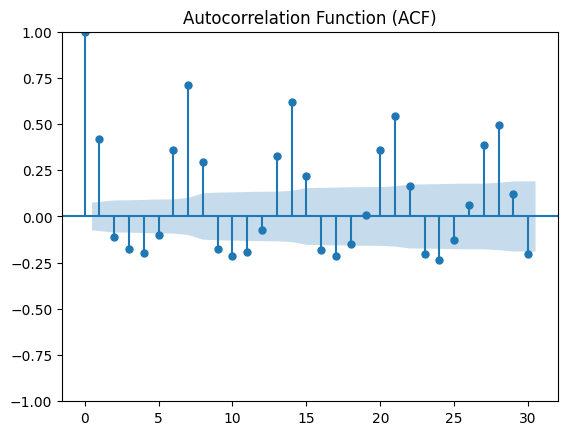

<Figure size 1000x500 with 0 Axes>

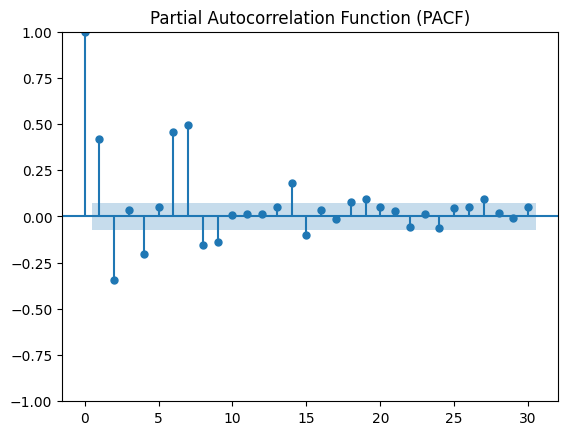

In [ ]:
# Hacer una copia del DataFrame original
dfc = df.copy()

# Agrupar por fecha y sumar los valores de 'Turnover'
dfc = dfc.groupby('date')['Turnover'].sum().reset_index()

# Establecer la columna 'date' como índice
dfc = dfc.set_index('date')

# Asegurarse de que la columna 'date' es de tipo datetime
dfc.index = pd.to_datetime(dfc.index)

# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(dfc['Turnover'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(dfc['Turnover'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

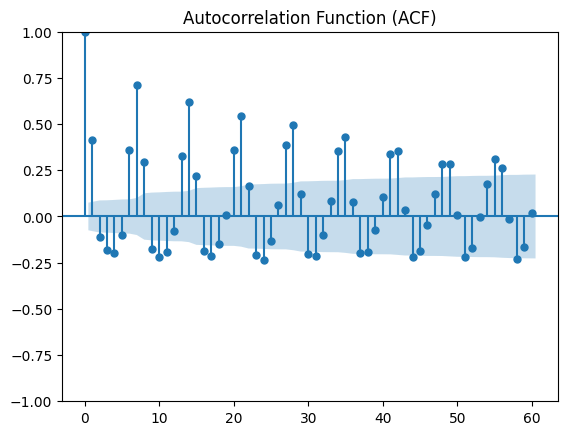

In [ ]:
plt.figure(figsize=(10, 5))
plot_acf(dfc['Turnover'], lags=60)
plt.title('Autocorrelation Function (ACF)')
plt.show()


<Figure size 1000x500 with 0 Axes>

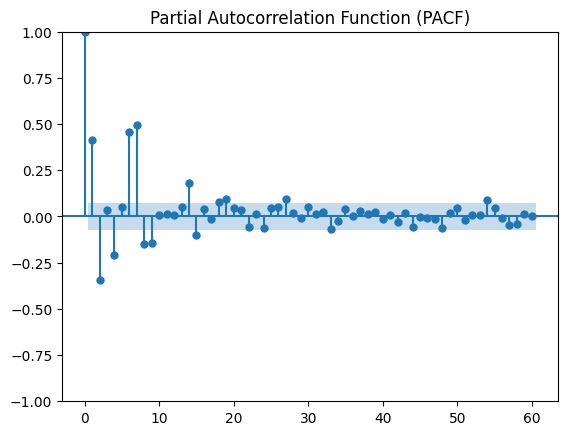

In [ ]:
plt.figure(figsize=(10, 5))
plot_pacf(dfc['Turnover'], lags=60)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# Obtener la fecha de inicio y término de la serie de tiempo
fecha_inicio = dfc.index.min()
fecha_termino = dfc.index.max()

print(f"La serie de tiempo parte el: {fecha_inicio}")
print(f"La serie de tiempo termina el: {fecha_termino}")

La serie de tiempo parte el: 2022-07-26 00:00:00
La serie de tiempo termina el: 2024-06-30 00:00:00


In [ ]:
# Generar un rango de fechas completo entre la fecha de inicio y la fecha de término
rango_completo = pd.date_range(start=dfc.index.min(), end=dfc.index.max(), freq='D')

# Identificar las fechas faltantes
fechas_faltantes = rango_completo.difference(dfc.index)

# Mostrar resultados
if fechas_faltantes.empty:
    print("No hay fechas faltantes en la serie de tiempo.")
else:
    print(f"Hay {len(fechas_faltantes)} fechas faltantes en la serie de tiempo:")
    print(fechas_faltantes)

Hay 20 fechas faltantes en la serie de tiempo:
DatetimeIndex(['2022-07-28', '2022-07-30', '2022-07-31', '2022-08-06',
               '2022-08-07', '2022-08-08', '2022-09-04', '2022-09-18',
               '2022-09-19', '2022-12-25', '2023-01-01', '2023-04-07',
               '2023-05-01', '2023-05-07', '2023-09-18', '2023-09-19',
               '2023-12-17', '2023-12-25', '2024-01-01', '2024-05-01'],
              dtype='datetime64[ns]', freq=None)


In [ ]:

# Reindexar el DataFrame para incluir las fechas faltantes
dfc = dfc.reindex(rango_completo)

# Interpolar los valores faltantes
dfc['Turnover'] = dfc['Turnover'].interpolate(method='time')

# Verificar si la interpolación fue exitosa
print("Valores interpolados:")
print(dfc.loc[fechas_faltantes])

Valores interpolados:
                Turnover
2022-07-28  6.776849e+05
2022-07-30  1.894627e+05
2022-07-31  9.497927e+04
2022-08-06  1.558146e+06
2022-08-07  1.039182e+06
2022-08-08  5.202168e+05
2022-09-04  9.945752e+06
2022-09-18  8.393511e+06
2022-09-19  8.343600e+06
2022-12-25  1.281784e+07
2023-01-01  1.552788e+07
2023-04-07  2.473150e+07
2023-05-01  1.870433e+07
2023-05-07  1.836453e+07
2023-09-18  1.112016e+07
2023-09-19  1.060048e+07
2023-12-17  1.902692e+07
2023-12-25  7.792526e+06
2024-01-01  7.446197e+06
2024-05-01  7.580971e+06


#Prueba de ADF


In [ ]:
# Prueba ADF (Dickey-Fuller Aumentada) para estacionaridad
result = adfuller(dfc['Turnover'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("La serie es estacionaria")
else:
    print("La serie no es estacionaria")

ADF Statistic: -2.980512354821939
p-value: 0.0367548153553043
Critical Values: {'1%': -3.4399324443722814, '5%': -2.865768564020576, '10%': -2.5690218258831052}
La serie es estacionaria


#Modelo LSTM


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import optuna
import time

# Asignar el DataFrame dff
dfls = dff.copy()

# Escalar la columna 'Turnover' entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
dfls['Turnover'] = scaler.fit_transform(dfls[['Turnover']])

# Definir la longitud de las secuencias
seq_length = 10  # Ajusta este valor según sea necesario

# Crear las secuencias para el modelo LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i+seq_length)].values  # Secuencias de entrada
        y = data['Turnover'].iloc[i+seq_length]  # Valor de Turnover a predecir
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Crear secuencias para el conjunto de entrenamiento y prueba
X, y = create_sequences(dfls, seq_length)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definir la función para construir el modelo LSTM
def build_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))
    model.add(Dense(1))  # Salida unidimensional para predecir "Turnover"

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

# Definir la función de objetivo para Optuna
def objective(trial):
    units = trial.suggest_int('units', 50, 200, step=50)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 10, 30, step=10)

    model = build_model(units=units, learning_rate=learning_rate)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0)

    score = model.evaluate(X_test, y_test, verbose=0)
    return score

# Callback para monitorear el progreso
class ProgressCallback:
    def __init__(self, n_trials):
        self.n_trials = n_trials
        self.start_time = time.time()

    def __call__(self, study, trial):
        elapsed = time.time() - self.start_time
        trials_done = len(study.trials)
        trials_left = self.n_trials - trials_done
        avg_time_per_trial = elapsed / trials_done
        time_left = avg_time_per_trial * trials_left

        print(f"Trial {trials_done}/{self.n_trials} completed.")
        print(f"Elapsed time: {elapsed/60:.2f} minutes")
        print(f"Estimated time remaining: {time_left/60:.2f} minutes")

# Crear el estudio de Optuna
n_trials = 20
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials, callbacks=[ProgressCallback(n_trials)])

# Mostrar los mejores parámetros
print(f"Mejores parámetros: {study.best_params}")
print(f"Mejor score: {study.best_value}")

# Obtener el mejor modelo con los parámetros óptimos
best_params = study.best_params
best_model = build_model(units=best_params['units'], learning_rate=best_params['learning_rate'])
best_model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], validation_split=0.2, verbose=0)

# Evaluar el modelo en el conjunto de prueba
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Hacer predicciones con el mejor modelo
predictions = best_model.predict(X_test)

# Desescalar las predicciones para compararlas con los valores reales
predictions = scaler.inverse_transform(predictions)

# Mostrar algunas predicciones desescaladas
for i in range(5):
    print(f"Predicción: {predictions[i]}, Real: {scaler.inverse_transform([[y_test[i]]])[0]}")

[I 2024-08-12 08:46:43,630] A new study created in memory with name: no-name-bce676a3-f587-4257-b082-dceb4568e7f6
<ipython-input-128-f2e928a46357>:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-08-12 08:46:58,871] Trial 0 finished with value: 0.01321178674697876 and parameters: {'units': 100, 'learning_rate': 0.001561293137978096, 'batch_size': 32, 'epochs': 30}. Best is trial 0 with value: 0.01321178674697876.


Trial 1/20 completed.
Elapsed time: 0.25 minutes
Estimated time remaining: 4.83 minutes


[I 2024-08-12 08:47:03,676] Trial 1 finished with value: 0.020250551402568817 and parameters: {'units': 100, 'learning_rate': 0.004928667079376191, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 0.01321178674697876.


Trial 2/20 completed.
Elapsed time: 0.33 minutes
Estimated time remaining: 3.01 minutes


[I 2024-08-12 08:47:24,584] Trial 2 finished with value: 0.015347305685281754 and parameters: {'units': 200, 'learning_rate': 0.00040999138922595264, 'batch_size': 16, 'epochs': 30}. Best is trial 0 with value: 0.01321178674697876.


Trial 3/20 completed.
Elapsed time: 0.68 minutes
Estimated time remaining: 3.87 minutes


[I 2024-08-12 08:47:29,835] Trial 3 finished with value: 0.04611378535628319 and parameters: {'units': 50, 'learning_rate': 0.0009027483499364046, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.01321178674697876.


Trial 4/20 completed.
Elapsed time: 0.77 minutes
Estimated time remaining: 3.08 minutes


[I 2024-08-12 08:47:35,019] Trial 4 finished with value: 0.046466875821352005 and parameters: {'units': 150, 'learning_rate': 0.000485172796684327, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.01321178674697876.


Trial 5/20 completed.
Elapsed time: 0.86 minutes
Estimated time remaining: 2.57 minutes


[I 2024-08-12 08:47:42,445] Trial 5 finished with value: 0.04228929057717323 and parameters: {'units': 50, 'learning_rate': 0.0006792627601877589, 'batch_size': 64, 'epochs': 30}. Best is trial 0 with value: 0.01321178674697876.


Trial 6/20 completed.
Elapsed time: 0.98 minutes
Estimated time remaining: 2.29 minutes


[I 2024-08-12 08:47:49,511] Trial 6 finished with value: 0.045030370354652405 and parameters: {'units': 100, 'learning_rate': 0.0004989893020229008, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: 0.01321178674697876.


Trial 7/20 completed.
Elapsed time: 1.10 minutes
Estimated time remaining: 2.04 minutes


[I 2024-08-12 08:48:01,384] Trial 7 finished with value: 0.01542946882545948 and parameters: {'units': 200, 'learning_rate': 0.006781780396826748, 'batch_size': 32, 'epochs': 20}. Best is trial 0 with value: 0.01321178674697876.


Trial 8/20 completed.
Elapsed time: 1.30 minutes
Estimated time remaining: 1.94 minutes


[I 2024-08-12 08:48:06,164] Trial 8 finished with value: 0.043845027685165405 and parameters: {'units': 100, 'learning_rate': 0.0011933496896189791, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 0.01321178674697876.


Trial 9/20 completed.
Elapsed time: 1.38 minutes
Estimated time remaining: 1.68 minutes


[I 2024-08-12 08:48:14,431] Trial 9 finished with value: 0.011278207413852215 and parameters: {'units': 50, 'learning_rate': 0.006099541561031758, 'batch_size': 16, 'epochs': 20}. Best is trial 9 with value: 0.011278207413852215.


Trial 10/20 completed.
Elapsed time: 1.51 minutes
Estimated time remaining: 1.51 minutes


[I 2024-08-12 08:48:21,536] Trial 10 finished with value: 0.04501035809516907 and parameters: {'units': 50, 'learning_rate': 0.00010437911481580191, 'batch_size': 16, 'epochs': 20}. Best is trial 9 with value: 0.011278207413852215.


Trial 11/20 completed.
Elapsed time: 1.63 minutes
Estimated time remaining: 1.33 minutes


[I 2024-08-12 08:48:41,951] Trial 11 finished with value: 0.011875610798597336 and parameters: {'units': 150, 'learning_rate': 0.002986710224796227, 'batch_size': 16, 'epochs': 30}. Best is trial 9 with value: 0.011278207413852215.


Trial 12/20 completed.
Elapsed time: 1.97 minutes
Estimated time remaining: 1.31 minutes


[I 2024-08-12 08:49:00,864] Trial 12 finished with value: 0.011305078864097595 and parameters: {'units': 150, 'learning_rate': 0.002990037427507204, 'batch_size': 16, 'epochs': 30}. Best is trial 9 with value: 0.011278207413852215.


Trial 13/20 completed.
Elapsed time: 2.29 minutes
Estimated time remaining: 1.23 minutes


[I 2024-08-12 08:49:15,383] Trial 13 finished with value: 0.012220113538205624 and parameters: {'units': 150, 'learning_rate': 0.009725206010266876, 'batch_size': 16, 'epochs': 20}. Best is trial 9 with value: 0.011278207413852215.


Trial 14/20 completed.
Elapsed time: 2.53 minutes
Estimated time remaining: 1.08 minutes


[I 2024-08-12 08:49:29,399] Trial 14 finished with value: 0.01380838267505169 and parameters: {'units': 150, 'learning_rate': 0.0030983970204766253, 'batch_size': 16, 'epochs': 20}. Best is trial 9 with value: 0.011278207413852215.


Trial 15/20 completed.
Elapsed time: 2.76 minutes
Estimated time remaining: 0.92 minutes


[I 2024-08-12 08:49:51,412] Trial 15 finished with value: 0.013627666048705578 and parameters: {'units': 200, 'learning_rate': 0.002560084750578969, 'batch_size': 16, 'epochs': 30}. Best is trial 9 with value: 0.011278207413852215.


Trial 16/20 completed.
Elapsed time: 3.13 minutes
Estimated time remaining: 0.78 minutes


[I 2024-08-12 08:49:58,778] Trial 16 finished with value: 0.014887185767292976 and parameters: {'units': 50, 'learning_rate': 0.005268344635061935, 'batch_size': 16, 'epochs': 20}. Best is trial 9 with value: 0.011278207413852215.


Trial 17/20 completed.
Elapsed time: 3.25 minutes
Estimated time remaining: 0.57 minutes


[I 2024-08-12 08:50:10,820] Trial 17 finished with value: 0.011778793297708035 and parameters: {'units': 100, 'learning_rate': 0.0023351456232056657, 'batch_size': 16, 'epochs': 30}. Best is trial 9 with value: 0.011278207413852215.


Trial 18/20 completed.
Elapsed time: 3.45 minutes
Estimated time remaining: 0.38 minutes


[I 2024-08-12 08:50:24,434] Trial 18 finished with value: 0.014577731490135193 and parameters: {'units': 150, 'learning_rate': 0.008485228053665693, 'batch_size': 16, 'epochs': 20}. Best is trial 9 with value: 0.011278207413852215.


Trial 19/20 completed.
Elapsed time: 3.68 minutes
Estimated time remaining: 0.19 minutes


[I 2024-08-12 08:50:39,776] Trial 19 finished with value: 0.011788353323936462 and parameters: {'units': 200, 'learning_rate': 0.004657912714855149, 'batch_size': 16, 'epochs': 20}. Best is trial 9 with value: 0.011278207413852215.


Trial 20/20 completed.
Elapsed time: 3.94 minutes
Estimated time remaining: 0.00 minutes
Mejores parámetros: {'units': 50, 'learning_rate': 0.006099541561031758, 'batch_size': 16, 'epochs': 20}
Mejor score: 0.011278207413852215
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 
Test Loss: 0.01369738020002842
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicción: [11287883.], Real: [9631817.6470289]
Predicción: [13830089.], Real: [11404719.3274174]
Predicción: [17684892.], Real: [22473311.7647421]
Predicción: [19727598.], Real: [20780605.8823405]
Predicción: [11310113.], Real: [11000575.6302581]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import optuna
import time
from sklearn.metrics import mean_absolute_percentage_error

# Asignar el DataFrame dff
dfls = dff.copy()

# Escalar la columna 'Turnover' entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
dfls['Turnover'] = scaler.fit_transform(dfls[['Turnover']])

# Definir la longitud de las secuencias
seq_length = 100  # Ajusta este valor según sea necesario

# Crear las secuencias para el modelo LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i+seq_length)].values  # Secuencias de entrada
        y = data['Turnover'].iloc[i+seq_length]  # Valor de Turnover a predecir
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Crear secuencias para el conjunto de entrenamiento y prueba
X, y = create_sequences(dfls, seq_length)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definir la función para construir el modelo LSTM
def build_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))
    model.add(Dense(1))  # Salida unidimensional para predecir "Turnover"

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

# Definir la función de objetivo para Optuna
def objective(trial):
    units = trial.suggest_int('units', 30, 60, step=10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16])
    epochs = trial.suggest_int('epochs', 10, 30, step=10)  # Hiperparámetro a optimizar

    model = build_model(units=units, learning_rate=learning_rate)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0)

    score = model.evaluate(X_test, y_test, verbose=0)
    return score

# Callback para monitorear el progreso
class ProgressCallback:
    def __init__(self, n_trials):
        self.n_trials = n_trials
        self.start_time = time.time()

    def __call__(self, study, trial):
        elapsed = time.time() - self.start_time
        trials_done = len(study.trials)
        trials_left = self.n_trials - trials_done
        avg_time_per_trial = elapsed / trials_done
        time_left = avg_time_per_trial * trials_left

        print(f"Trial {trials_done}/{self.n_trials} completed.")
        print(f"Elapsed time: {elapsed/60:.2f} minutes")
        print(f"Estimated time remaining: {time_left/60:.2f} minutes")

# Crear el estudio de Optuna
n_trials = 20
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials, callbacks=[ProgressCallback(n_trials)])

# Mostrar los mejores parámetros
print(f"Mejores parámetros: {study.best_params}")
print(f"Mejor score: {study.best_value}")

# Obtener el mejor modelo con los parámetros óptimos
best_params = study.best_params
best_model = build_model(units=best_params['units'], learning_rate=best_params['learning_rate'])
best_model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], validation_split=0.2, verbose=0)

# Evaluar el modelo en el conjunto de prueba
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Hacer predicciones con el mejor modelo
predictions = best_model.predict(X_test)

# Desescalar las predicciones para compararlas con los valores reales
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # Ajustar el reshape

# Desescalar los valores reales para compararlas con las predicciones
y_test_descaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular y mostrar el MAPE
mape = mean_absolute_percentage_error(y_test_descaled, predictions)
print(f"MAPE: {mape:.2f}%")

# Mostrar algunas predicciones desescaladas
for i in range(5):
    print(f"Predicción: {predictions[i]}, Real: {y_test_descaled[i]}")

[I 2024-08-15 15:44:09,182] A new study created in memory with name: no-name-a5fef6cf-d768-415f-9269-93c69cefc066
<ipython-input-15-105d65dc210d>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
[I 2024-08-15 15:45:48,241] Trial 0 finished with value: 0.013526749797165394 and parameters: {'units': 40, 'learning_rate': 0.002130497822227378, 'batch_size': 4, 'epochs': 30}. Best is trial 0 with value: 0.013526749797165394.


Trial 1/20 completed.
Elapsed time: 1.65 minutes
Estimated time remaining: 31.37 minutes


[I 2024-08-15 15:47:53,778] Trial 1 finished with value: 0.013539271429181099 and parameters: {'units': 60, 'learning_rate': 0.00862354295137997, 'batch_size': 4, 'epochs': 30}. Best is trial 0 with value: 0.013526749797165394.


Trial 2/20 completed.
Elapsed time: 3.74 minutes
Estimated time remaining: 33.69 minutes


[I 2024-08-15 15:49:33,129] Trial 2 finished with value: 0.01184108480811119 and parameters: {'units': 30, 'learning_rate': 0.0022255405837229266, 'batch_size': 4, 'epochs': 30}. Best is trial 2 with value: 0.01184108480811119.


Trial 3/20 completed.
Elapsed time: 5.40 minutes
Estimated time remaining: 30.60 minutes


[I 2024-08-15 15:50:27,314] Trial 3 finished with value: 0.013184236362576485 and parameters: {'units': 30, 'learning_rate': 0.0025358008089571412, 'batch_size': 8, 'epochs': 30}. Best is trial 2 with value: 0.01184108480811119.


Trial 4/20 completed.
Elapsed time: 6.30 minutes
Estimated time remaining: 25.21 minutes


[I 2024-08-15 15:50:52,291] Trial 4 finished with value: 0.015523653477430344 and parameters: {'units': 40, 'learning_rate': 0.0020273392123206927, 'batch_size': 16, 'epochs': 20}. Best is trial 2 with value: 0.01184108480811119.


Trial 5/20 completed.
Elapsed time: 6.72 minutes
Estimated time remaining: 20.16 minutes


[I 2024-08-15 15:52:25,218] Trial 5 finished with value: 0.012036328203976154 and parameters: {'units': 60, 'learning_rate': 0.004109825799659669, 'batch_size': 4, 'epochs': 20}. Best is trial 2 with value: 0.01184108480811119.


Trial 6/20 completed.
Elapsed time: 8.27 minutes
Estimated time remaining: 19.29 minutes


[I 2024-08-15 15:52:58,829] Trial 6 finished with value: 0.013986551202833652 and parameters: {'units': 30, 'learning_rate': 0.005446749626933095, 'batch_size': 4, 'epochs': 10}. Best is trial 2 with value: 0.01184108480811119.


Trial 7/20 completed.
Elapsed time: 8.83 minutes
Estimated time remaining: 16.39 minutes


[I 2024-08-15 15:53:40,617] Trial 7 finished with value: 0.015134593471884727 and parameters: {'units': 60, 'learning_rate': 0.0018755663538499777, 'batch_size': 8, 'epochs': 20}. Best is trial 2 with value: 0.01184108480811119.


Trial 8/20 completed.
Elapsed time: 9.52 minutes
Estimated time remaining: 14.29 minutes


[I 2024-08-15 15:54:07,035] Trial 8 finished with value: 0.013993475586175919 and parameters: {'units': 60, 'learning_rate': 0.0026658955924540565, 'batch_size': 8, 'epochs': 10}. Best is trial 2 with value: 0.01184108480811119.


Trial 9/20 completed.
Elapsed time: 9.96 minutes
Estimated time remaining: 12.18 minutes


[I 2024-08-15 15:54:34,518] Trial 9 finished with value: 0.020265337079763412 and parameters: {'units': 60, 'learning_rate': 0.0018154462864647166, 'batch_size': 8, 'epochs': 10}. Best is trial 2 with value: 0.01184108480811119.


Trial 10/20 completed.
Elapsed time: 10.42 minutes
Estimated time remaining: 10.42 minutes


[I 2024-08-15 15:55:11,480] Trial 10 finished with value: 0.01858435571193695 and parameters: {'units': 30, 'learning_rate': 0.0010672902596891042, 'batch_size': 16, 'epochs': 30}. Best is trial 2 with value: 0.01184108480811119.


Trial 11/20 completed.
Elapsed time: 11.04 minutes
Estimated time remaining: 9.03 minutes


[I 2024-08-15 15:56:32,285] Trial 11 finished with value: 0.011161626316606998 and parameters: {'units': 50, 'learning_rate': 0.004226634031707651, 'batch_size': 4, 'epochs': 20}. Best is trial 11 with value: 0.011161626316606998.


Trial 12/20 completed.
Elapsed time: 12.39 minutes
Estimated time remaining: 8.26 minutes


[I 2024-08-15 15:58:02,079] Trial 12 finished with value: 0.012094970792531967 and parameters: {'units': 50, 'learning_rate': 0.0042104437319939415, 'batch_size': 4, 'epochs': 20}. Best is trial 11 with value: 0.011161626316606998.


Trial 13/20 completed.
Elapsed time: 13.88 minutes
Estimated time remaining: 7.47 minutes


[I 2024-08-15 15:59:22,133] Trial 13 finished with value: 0.013813718222081661 and parameters: {'units': 50, 'learning_rate': 0.0012308666033080977, 'batch_size': 4, 'epochs': 20}. Best is trial 11 with value: 0.011161626316606998.


Trial 14/20 completed.
Elapsed time: 15.22 minutes
Estimated time remaining: 6.52 minutes


[I 2024-08-15 16:01:10,499] Trial 14 finished with value: 0.014558629132807255 and parameters: {'units': 40, 'learning_rate': 0.005901517725992417, 'batch_size': 4, 'epochs': 30}. Best is trial 11 with value: 0.011161626316606998.


Trial 15/20 completed.
Elapsed time: 17.02 minutes
Estimated time remaining: 5.67 minutes


[I 2024-08-15 16:02:34,454] Trial 15 finished with value: 0.013241632841527462 and parameters: {'units': 50, 'learning_rate': 0.003373040902046927, 'batch_size': 4, 'epochs': 20}. Best is trial 11 with value: 0.011161626316606998.


Trial 16/20 completed.
Elapsed time: 18.42 minutes
Estimated time remaining: 4.61 minutes


[I 2024-08-15 16:03:11,203] Trial 16 finished with value: 0.0133393919095397 and parameters: {'units': 40, 'learning_rate': 0.00838627289669126, 'batch_size': 16, 'epochs': 30}. Best is trial 11 with value: 0.011161626316606998.


Trial 17/20 completed.
Elapsed time: 19.03 minutes
Estimated time remaining: 3.36 minutes


[I 2024-08-15 16:03:58,963] Trial 17 finished with value: 0.01758812926709652 and parameters: {'units': 50, 'learning_rate': 0.0015832475538540471, 'batch_size': 4, 'epochs': 10}. Best is trial 11 with value: 0.011161626316606998.


Trial 18/20 completed.
Elapsed time: 19.83 minutes
Estimated time remaining: 2.20 minutes


[I 2024-08-15 16:05:03,720] Trial 18 finished with value: 0.0158204585313797 and parameters: {'units': 30, 'learning_rate': 0.003403647497175024, 'batch_size': 4, 'epochs': 20}. Best is trial 11 with value: 0.011161626316606998.


Trial 19/20 completed.
Elapsed time: 20.91 minutes
Estimated time remaining: 1.10 minutes


[I 2024-08-15 16:05:26,560] Trial 19 finished with value: 0.012377644889056683 and parameters: {'units': 40, 'learning_rate': 0.0059791026383526884, 'batch_size': 16, 'epochs': 20}. Best is trial 11 with value: 0.011161626316606998.


Trial 20/20 completed.
Elapsed time: 21.29 minutes
Estimated time remaining: 0.00 minutes
Mejores parámetros: {'units': 50, 'learning_rate': 0.004226634031707651, 'batch_size': 4, 'epochs': 20}
Mejor score: 0.011161626316606998
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0099
Test Loss: 0.012144450098276138
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
MAPE: 0.20%
Predicción: [11019265.], Real: [10455408.4033006]
Predicción: [9297597.], Real: [10119015.1259564]
Predicción: [9132287.], Real: [9935861.3447063]
Predicción: [8493375.], Real: [9706334.4538415]
Predicción: [14498104.], Real: [12517528.5713771]


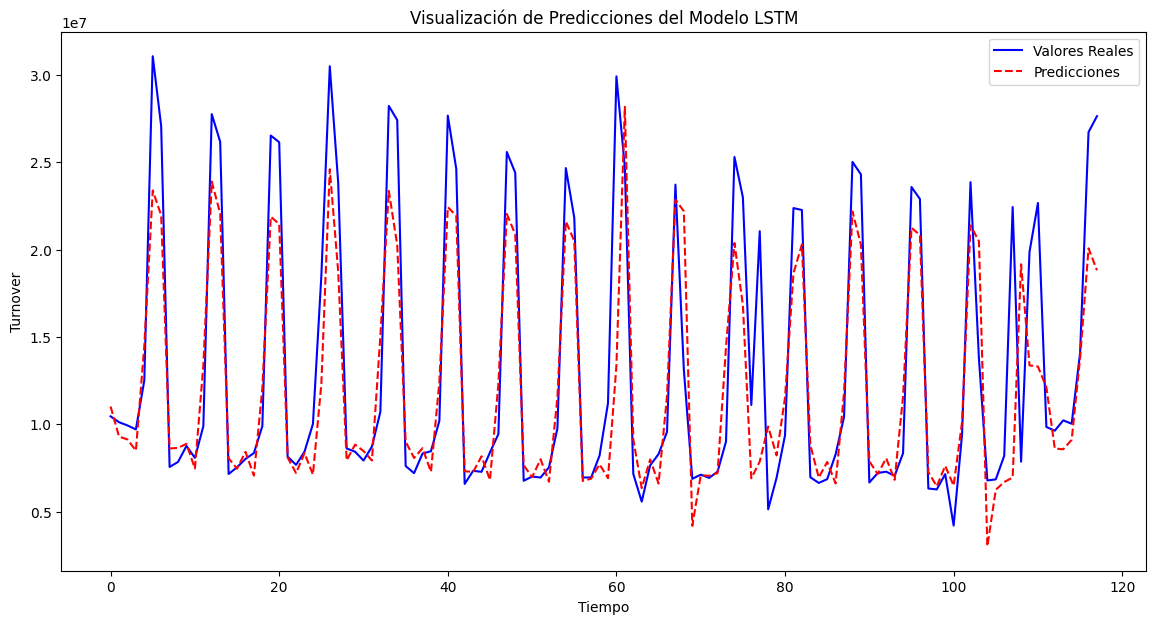

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico para visualizar la serie temporal, los valores reales y las predicciones
plt.figure(figsize=(14, 7))

# Graficar los valores reales
plt.plot(range(len(y_test_descaled)), y_test_descaled, label='Valores Reales', color='blue')

# Graficar las predicciones
plt.plot(range(len(predictions)), predictions, label='Predicciones', color='red', linestyle='--')

# Añadir título y etiquetas
plt.title('Visualización de Predicciones del Modelo LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Turnover')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()